In [1]:
import requests
import math
from datetime import datetime, timezone, timedelta
import pandas as pd
from pandas.io.json import json_normalize
from pytrends.request import TrendReq
import matplotlib.pyplot as plt
import numpy as np
import os
import shutil

## Data Pre-Processing

In [2]:
def download_ohlcv(symbol, start_date, end_date):
    date_iterator = start_date - timedelta(hours=1)
    
    ohlcv_df = pd.DataFrame()
    
    while date_iterator < end_date:
        delta = timedelta(seconds=min((end_date - date_iterator).total_seconds(), 2000 * 3600))
        limit = delta.total_seconds() // 3600 - 1
        date_iterator += delta
        
        params={
            'fsym': symbol,
            'tsym': 'USD',
            'limit': limit,
            'toTs': date_iterator.timestamp()
        }
        
        r = requests.get('https://min-api.cryptocompare.com/data/histohour', params=params)
        data = json_normalize(r.json(), record_path="Data")
        ohlcv_df = ohlcv_df.append(data)

    ohlcv_df['time'] = pd.to_datetime(ohlcv_df['time'], unit='s')
    ohlcv_df.set_index('time', inplace=True)
    ohlcv_df = ohlcv_df.tz_localize('UTC')
    
    return ohlcv_df

In [3]:
def download_trends(keyword, start_date, end_date):
    pytrends = TrendReq()

    delta = timedelta(days=7)
    date_iterator = start_date

    trends_df = pd.DataFrame()
    
    while date_iterator < end_date:
        week_start = date_iterator.strftime('%Y-%m-%dT%H')
        week_end = (date_iterator + delta).strftime('%Y-%m-%dT%H')
        tf = week_start + ' ' + week_end

        pytrends.build_payload([keyword], timeframe=tf)
        week_df = pytrends.interest_over_time()

        if (not trends_df.empty):
            ratio = trends_df[trends_df.index == date_iterator].iloc[0][keyword] / week_df[week_df.index == date_iterator].iloc[0][keyword]
            trends_df[keyword] /= ratio

        trends_df = trends_df.append(week_df)
        
        date_iterator += delta
        
    trends_df = trends_df[~trends_df.index.duplicated(keep='last')]
    trends_df.rename(columns={keyword: 'trend'}, inplace=True)
    trends_df.drop(columns='isPartial', inplace=True)
    trends_df['trend'] *= 100 / np.max(trends_df['trend'])
    trends_df = trends_df.tz_localize('UTC')
    
    return trends_df

In [4]:
start_date = datetime(2018, 3, 30, 0)
end_date = datetime(2018, 9, 30, 0)
symbol = 'BTC'
keyword = 'Bitcoin'

In [5]:
ohlcv_df = download_ohlcv('BTC', start_date, end_date)

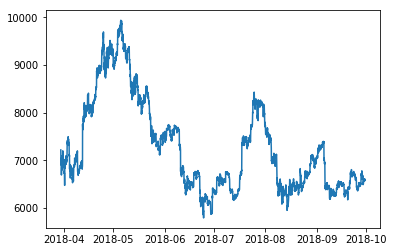

In [6]:
plt.plot(ohlcv_df.index.values, ohlcv_df['close'])

In [7]:
trends_df = download_trends('Bitcoin', start_date, end_date)

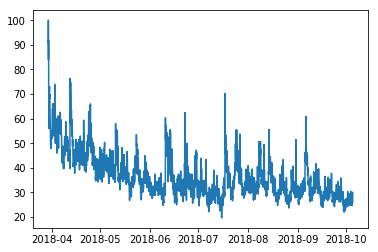

In [8]:
plt.plot(trends_df.index.values, trends_df['trend'])

In [9]:
raw_df = ohlcv_df.join(trends_df, how="inner")

In [10]:
proc_df = pd.DataFrame()

proc_df['open_close_ratio'] = raw_df['open'] / raw_df['close'] - 1
proc_df['high_low_ratio'] = raw_df['high'] / raw_df['low'] - 1

proc_df['close_pct_change_1hr'] = raw_df['close'].pct_change()
proc_df['close_pct_change_6hr'] = raw_df['close'].pct_change(periods=6)
proc_df['close_pct_change_12hr'] = raw_df['close'].pct_change(periods=12)
proc_df['close_pct_change_24hr'] = raw_df['close'].pct_change(periods=24)

proc_df['volume_pct_change_1hr'] = raw_df['volumefrom'].pct_change()
proc_df['volume_pct_change_6hr'] = raw_df['volumefrom'].pct_change(periods=6)
proc_df['volume_pct_change_12hr'] = raw_df['volumefrom'].pct_change(periods=12)
proc_df['volume_pct_change_24hr'] = raw_df['volumefrom'].pct_change(periods=24)

proc_df['trend_pct_change_1hr'] = raw_df['trend'].pct_change()
proc_df['trend_pct_change_6hr'] = raw_df['trend'].pct_change(periods=6)
proc_df['trend_pct_change_12hr'] = raw_df['trend'].pct_change(periods=12)
proc_df['trend_pct_change_24hr'] = raw_df['trend'].pct_change(periods=24)

proc_df.dropna(inplace=True)

## Model

In [11]:
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
tf.logging.set_verbosity(tf.logging.ERROR)

In [12]:
scaler = MinMaxScaler()
directions = np.sign(proc_df['close_pct_change_1hr']).astype(np.int)
directions[directions == -1] = 0
scaled_df = pd.DataFrame(scaler.fit_transform(proc_df), index=proc_df.index, columns=proc_df.columns)

In [13]:
unrolled_cells = 12
step = 1
num_features = len(scaled_df.columns)
learning_rate = 1e-4
num_epoch= 5000
batch_size= 64
num_layers = 5
layer_size = 20
lambda_l2 = 0.0005
display_loss_step = 20
save_model_step = 50

In [14]:
sequences = []
targets = []

for i in range(0, len(scaled_df) - unrolled_cells, step):
    sequences.append(scaled_df[i:i+unrolled_cells].values)
#     targets.append([scaled_df['close_pct_change_1hr'][i+unrolled_cells]])
    targets.append([directions[i+unrolled_cells]])

dates = scaled_df.index[unrolled_cells:]

In [15]:
test_split = int(len(sequences)*.90)
val_split = int(len(sequences)*.75)
train_sequences, train_targets = sequences[:val_split], targets[:val_split]
val_sequences, val_targets = sequences[val_split:test_split], targets[val_split:test_split]
test_sequences, test_targets = sequences[test_split:], targets[test_split:]
train_dates, val_dates, test_dates = dates[:val_split], dates[val_split:test_split], dates[test_split:]

In [24]:
X = np.array(test_sequences[:32])

In [26]:
tf.unstack(X, unrolled_cells, axis=1)

[<tf.Tensor 'unstack:0' shape=(32, 14) dtype=float64>,
 <tf.Tensor 'unstack:1' shape=(32, 14) dtype=float64>,
 <tf.Tensor 'unstack:2' shape=(32, 14) dtype=float64>,
 <tf.Tensor 'unstack:3' shape=(32, 14) dtype=float64>,
 <tf.Tensor 'unstack:4' shape=(32, 14) dtype=float64>,
 <tf.Tensor 'unstack:5' shape=(32, 14) dtype=float64>,
 <tf.Tensor 'unstack:6' shape=(32, 14) dtype=float64>,
 <tf.Tensor 'unstack:7' shape=(32, 14) dtype=float64>,
 <tf.Tensor 'unstack:8' shape=(32, 14) dtype=float64>,
 <tf.Tensor 'unstack:9' shape=(32, 14) dtype=float64>,
 <tf.Tensor 'unstack:10' shape=(32, 14) dtype=float64>,
 <tf.Tensor 'unstack:11' shape=(32, 14) dtype=float64>]

In [179]:
def lstm_cell_with_dropout():
    lstm_cell = tf.contrib.rnn.LSTMBlockCell(layer_size)
    return tf.nn.rnn_cell.DropoutWrapper(lstm_cell, output_keep_prob=0.5, input_keep_prob=0.5)

tf.reset_default_graph()    

X = tf.placeholder('float', [None, unrolled_cells, num_features], name='X')
Y = tf.placeholder('float', [None, 1], name='Y')

with tf.name_scope('input'):
    x = tf.unstack(X, unrolled_cells, axis=1)

with tf.name_scope('rnn'):
    stacked_lstm = tf.contrib.rnn.MultiRNNCell([lstm_cell_with_dropout() for _ in range(5)])
    rnn_outputs, rnn_states = tf.contrib.rnn.static_rnn(stacked_lstm, x, dtype=tf.float32)

    rnn_weights = stacked_lstm.weights[0]
    rnn_biases = stacked_lstm.weights[1]
    
    tf.summary.histogram("outputs", rnn_outputs)
    tf.summary.histogram("states", rnn_states)
    tf.summary.histogram("rnn_weights", rnn_weights)
    tf.summary.histogram("rnn_biases", rnn_biases)
    
    
with tf.name_scope('nn'):
    prediction = tf.layers.dense(rnn_outputs[-1], 1, activation=tf.nn.sigmoid, name='nn1')
    
    with tf.variable_scope("nn1", reuse=True):
        nn1_weights = tf.get_variable('kernel')
        nn1_biases = tf.get_variable('bias')
        
    tf.summary.histogram("nn1_weights", nn1_weights)
    tf.summary.histogram("nn1_biases", nn1_biases)
    tf.summary.histogram("train_prediction", prediction)

with tf.name_scope('loss'):
#     mse = tf.losses.mean_squared_error(Y, prediction)
    log_loss = tf.losses.log_loss(Y, prediction)
    weights = [rnn_weights, nn1_weights]
    l2 = lambda_l2 * tf.reduce_sum([ tf.nn.l2_loss(v) for v in weights])
#     loss = tf.add(mse, l2, name='loss')
    loss = tf.add(log_loss, l2, name='loss')
    train_loss_summ = tf.summary.scalar('train_loss', loss, collections = 'evaluation')
    val_loss_summ = tf.summary.scalar('val_loss', loss, collections = 'evaluation')

with tf.name_scope('optimizer'):
    optimizer = tf.train.AdamOptimizer(learning_rate, name='optimizer')
    
with tf.name_scope('train'):
    minimize = optimizer.minimize(loss, name = 'minimize')

In [180]:
init = tf.global_variables_initializer()

base_dir = './rnn'
file_writer_dir = '{}/run1/logs'.format(base_dir)
save_model_dir = '{}/run1/model'.format(base_dir)

if os.path.exists(base_dir):
    shutil.rmtree(base_dir)

In [181]:
with tf.Session() as sess:
    sess.run(init)
    
    merged_summary = tf.summary.merge_all()
    
    writer = tf.summary.FileWriter(file_writer_dir)
    writer.add_graph(sess.graph)
    
    for epoch in range(1, num_epoch+1):
        for start in range(0, len(train_sequences) + 1, batch_size):
            batch_x = train_sequences[start:min(start+batch_size, len(train_sequences))]
            batch_y = train_targets[start:min(start+batch_size, len(train_targets))]
            
            sess.run(minimize, feed_dict={X: batch_x, Y: batch_y})
        
        summ = sess.run(merged_summary, feed_dict={X: batch_x, Y: batch_y})
        writer.add_summary(summ, epoch)
        
        if epoch % display_loss_step == 0 or epoch == 1:
            train_loss, train_prediction, train_summ = sess.run([loss, prediction, train_loss_summ], feed_dict={X: train_sequences, Y: train_targets})
            val_loss, val_prediction, val_summ = sess.run([loss, prediction, val_loss_summ], feed_dict={X: val_sequences, Y: val_targets})
            
            writer.add_summary(train_summ, epoch)
            writer.add_summary(val_summ, epoch)
            
            print(epoch, train_loss, val_loss)
        
        if epoch % save_model_step == 0 or epoch == 1:
            tf.saved_model.simple_save(sess, f'{save_model_dir}/epoch{epoch}', inputs={"x": X}, outputs={"y": Y})

1 0.7049833 0.7059885
20 0.697424 0.6982201
40 0.6950928 0.69503295
60 0.69443136 0.6940609
80 0.6939334 0.6939455
100 0.69359386 0.69426626
120 0.69368917 0.693671
140 0.6936007 0.69347167
160 0.69355637 0.6930916
180 0.6934771 0.6932186
200 0.6933518 0.6935227
220 0.6935599 0.69337004
240 0.69322425 0.69313425
260 0.69330096 0.6934419
280 0.69327503 0.69310427
300 0.69309086 0.69337964
320 0.693174 0.6940883
340 0.6929352 0.693571
360 0.6929976 0.6935746
380 0.69356596 0.6926294
400 0.6931675 0.69297105
420 0.6932248 0.6936422
440 0.69298834 0.692949
460 0.6928713 0.6930303
480 0.6934756 0.69390273
500 0.69298977 0.69239384
520 0.693489 0.69308424
540 0.69303596 0.6934843
560 0.6936556 0.6930451
580 0.6925166 0.69323397
600 0.6926583 0.6943431
620 0.69368994 0.6943199
640 0.69298303 0.69275296
660 0.6927897 0.6935412
680 0.6929057 0.69370496
700 0.69311804 0.6943201
720 0.6930465 0.69430447
740 0.6926865 0.6943933
760 0.69256747 0.69470394
780 0.69263625 0.69587773
800 0.6932106 0.69

KeyboardInterrupt: 

In [203]:
checkpoint_epoch = 1000
graph = tf.Graph()

with graph.as_default():
    with tf.Session(graph=graph) as sess:
        tf.saved_model.loader.load(sess, [tf.saved_model.tag_constants.SERVING], f'{save_model_dir}/epoch{checkpoint_epoch}')
        
        X = graph.get_tensor_by_name('X:0')
        Y = graph.get_tensor_by_name("Y:0")
        
        prediction = graph.get_tensor_by_name('nn/nn1/BiasAdd:0')
        loss = graph.get_tensor_by_name('loss/loss:0')
        
        train_loss, train_prediction = sess.run([loss, prediction], feed_dict={X: train_sequences, Y: train_targets})
        val_loss, val_prediction = sess.run([loss, prediction], feed_dict={X: val_sequences, Y: val_targets})
        test_loss, test_prediction = sess.run([loss, prediction], feed_dict={X: test_sequences, Y: test_targets})
        
        print(train_loss, val_loss, test_loss)

0.0073904507 0.0054266225 0.0035689608


In [206]:
test_df = scaled_df.copy()
test_preds = test_prediction.squeeze()
test_df = test_df[:len(test_preds)]
test_df['close_pct_change_1hr'] = test_preds
test_df = pd.DataFrame(scaler.inverse_transform(test_df), columns=proc_df.columns)

In [207]:
mean_direction_accuracy = np.sum(np.sign(proc_df.loc[test_dates]['close_pct_change_1hr'].values) == np.sign(test_df['close_pct_change_1hr'].values)) / len(test_df)

In [209]:
mean_direction_accuracy

0.5034168564920274